In [1]:
import sys
from math import pi

import matplotlib.pyplot as plt
import torch
import torchaudio

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import dstft
from dstft.loss import entropy_loss
from dstft import DSTFT, FDSTFT

In [3]:
sr = 1e4
t = torch.arange(0, 2.5, 1/sr)
f = torch.sin(2*pi*t) * 1e2 + 1e2 * torch.ones_like(t) + 5e1 * t
x = (torch.sin(torch.cumsum(f, dim=0) / 2e2) + 0.1 *torch.randn(t.shape))[None, :]
x += torch.sin(torch.cumsum(1e2*5 * torch.ones_like(t), dim=0) / 2e2)
x = x.to(device)
print(x.shape)

torch.Size([1, 25000])


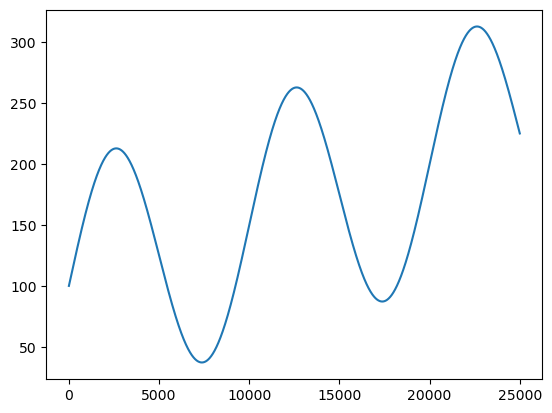

In [4]:
plt.plot(f)

Text(0.5, 0, 'frames')

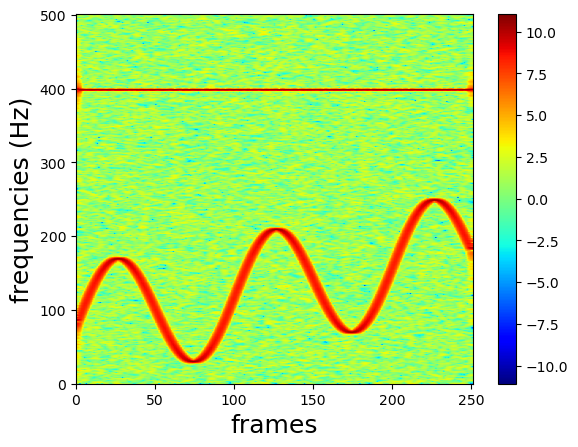

In [5]:
spec = torchaudio.transforms.Spectrogram(n_fft=1_000, win_length=1_000, hop_length=100)(x.cpu())
ax = plt.subplot()
im = ax.imshow(spec[0].log().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
plt.colorbar(im, ax=ax)
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

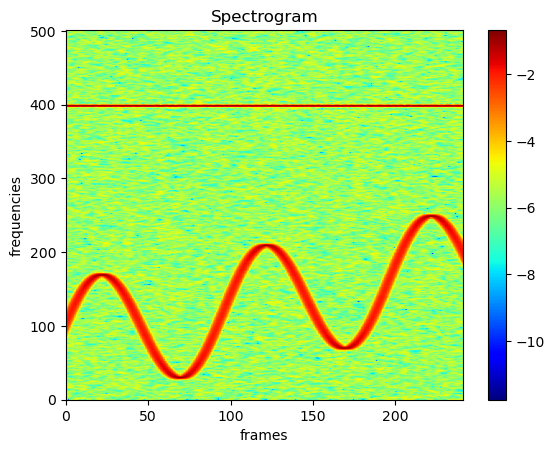

In [6]:
dstft = FDSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

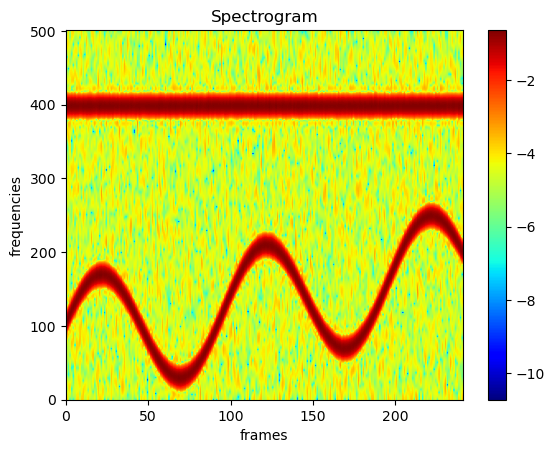

In [7]:
dspec = FDSTFT(x, win_length=100, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ = dspec(x)
dspec.print(spec, weights=False, wins=False, bar=True)

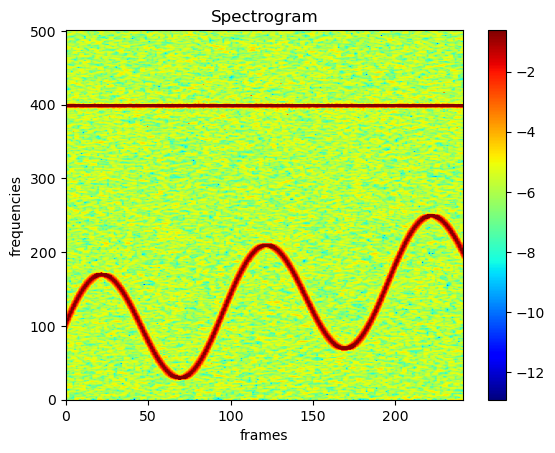

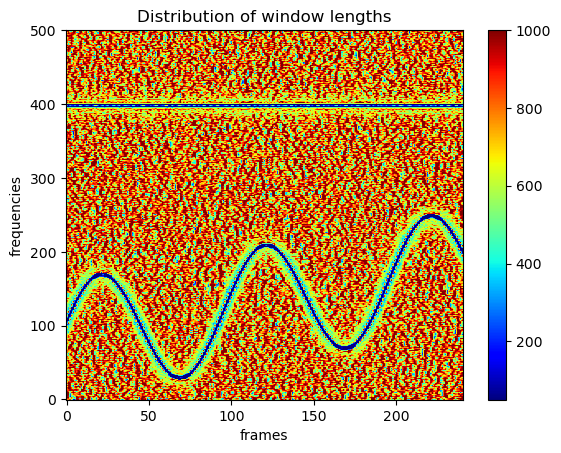

In [8]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf')
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt)

for epoch in range(10):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
dstft.print(spec, wins=False, bar=True)
spec1 = spec

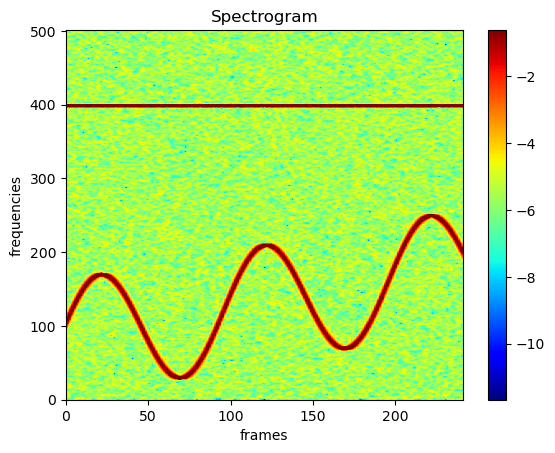

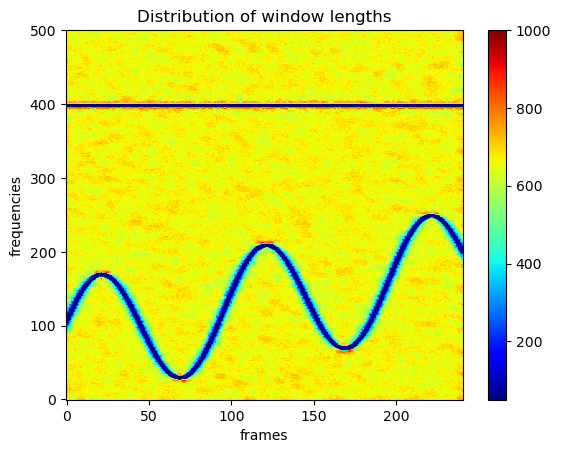

In [9]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf')
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt)

for epoch in range(10):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
dstft.print(spec, wins=False, bar=True)
spec1 = spec